In [22]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import scipy.special

In [23]:
warnings.filterwarnings(action = 'ignore')

In [24]:
# # issue
# X_train.ID.unique().shape

# LSTM


In [25]:
orginal_data = pd.read_csv("oasis_longitudinal.csv")
mu_eTIV, sigma_eTIV = orginal_data['eTIV'].mean(), orginal_data['eTIV'].var()
mu_MMSE, sigma_MMSE = orginal_data['MMSE'].mean(), orginal_data['MMSE'].var()
mu_EDUC, sigma_EDUC = orginal_data['EDUC'].mean(), orginal_data['EDUC'].var()
age_range = (60, 100)

def build_lstm_rnn(INPUT_SHAPE):
    lstm_rnn = tf.keras.Sequential()
    lstm_rnn.add(tf.keras.layers.LSTM(100, return_sequences=True, input_shape=INPUT_SHAPE))
    lstm_rnn.add(tf.keras.layers.LSTM(50, return_sequences=False))
    lstm_rnn.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    lstm_rnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return lstm_rnn

1/1 [==============================] - 1s 733ms/step
Accuracy List: [0.65, 0.45, 0.5]
Recall List: [1.0, 1.0, 1.0]
Precision List: [1.0, 1.0, 1.0]


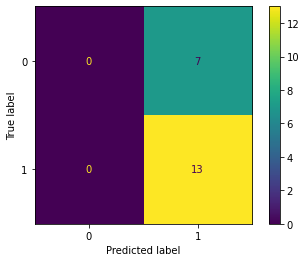

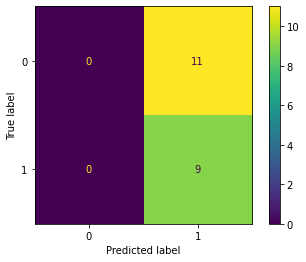

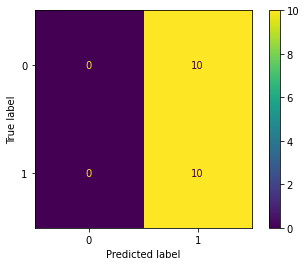

In [26]:
accuracy_list_lstm = []
recall_list_lstm = []
precision_list_lstm = []
for _ in range(3):
    N = 100
    m = 5

    Y = eta = np.zeros((N, m))
    Age = np.random.choice(range(age_range[0], age_range[1] + 1), size=N)
    MMSE = np.round(np.random.normal(mu_MMSE, sigma_MMSE, size=N))
    EDUC = np.round(np.random.normal(mu_EDUC, sigma_EDUC, size=N))
    Sex = np.random.binomial(1, 0.2, size=N)
    eTIV = np.round(np.random.normal(mu_eTIV, sigma_eTIV, size=N))
    ASF = np.random.normal(size=N)
    nWBV = np.random.normal(size=N)
    Visit = np.round(np.linspace(0, 4, num=m))

    B = np.array([0.1, -0.1, 0.2, -0.2, 0.3, 0.3, 0.1, 0.1, 0.2, 0.1])
    b = np.random.normal(0, 0.5, size = N)

    for i in range(N):
        for j in range(m):
            eta[i, j] = B[0] + B[1] * Visit[j] + B[2] * Age[i] + B[3] * MMSE[i] + B[4] * EDUC[i] + B[5] * Sex[i] + \
                        B[6] * eTIV[i] + B[7] * ASF[i] + B[8] * nWBV[i] + b[i]
            p = scipy.special.expit(eta[i, j])
            Y[i, j] = np.random.binomial(1, p)



    mat = np.empty((N * m, 10))
    p = 0
    for i in range(N):
        jk = 0
        for jj in range(p, p + m):
            mat[jj, 0] = i + 1
            mat[jj, 1] = Visit[jk]
            mat[jj, 2] = Age[i]
            mat[jj, 3] = MMSE[i]
            mat[jj, 4] = EDUC[i]
            mat[jj, 5] = Sex[i]
            mat[jj, 6] = eTIV[jk]
            mat[jj, 7] = ASF[jk]
            mat[jj, 8] = nWBV[jk]
            mat[jj, 9] = Y[i, jk]
            jk += 1
        p += m
    # Convert the `mat` array to a DataFrame
    df_mat = pd.DataFrame(mat, columns=['ID', 'Visit', 'Age', 'MMSE', 'EDUC', 'Sex', 'eTIV', 'ASF', 'nWBV', 'Y'])
    df = pd.get_dummies(df_mat, columns=["Visit"], prefix="Visit")
    RANDOM_STATE = 13
    splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state=RANDOM_STATE)
    split = splitter.split(df, groups=df['ID'])
    train_indexes, test_indexes = next(split)

    X_train = df.iloc[train_indexes]
    X_test = df.iloc[test_indexes]
    age_scaler = MinMaxScaler()
    educ_scaler = MinMaxScaler()
    mmse_scaler = MinMaxScaler()
    etiv_scaler = MinMaxScaler()

    age_scaler.fit(X_train["Age"].to_numpy().reshape(-1, 1))
    educ_scaler.fit(X_train["EDUC"].to_numpy().reshape(-1, 1))
    mmse_scaler.fit(X_train["MMSE"].to_numpy().reshape(-1, 1))
    etiv_scaler.fit(X_train["eTIV"].to_numpy().reshape(-1, 1))

    X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1, 1))
    X_train["EDUC"] = educ_scaler.transform(X_train["EDUC"].to_numpy().reshape(-1, 1))
    X_train["MMSE"] = mmse_scaler.transform(X_train["MMSE"].to_numpy().reshape(-1, 1))
    X_train["eTIV"] = etiv_scaler.transform(X_train["eTIV"].to_numpy().reshape(-1, 1))

    X_test["Age"] = age_scaler.transform(X_test["Age"].to_numpy().reshape(-1, 1))
    X_test["EDUC"] = educ_scaler.transform(X_test["EDUC"].to_numpy().reshape(-1, 1))
    X_test["MMSE"] = mmse_scaler.transform(X_test["MMSE"].to_numpy().reshape(-1, 1))
    X_test["eTIV"] = mmse_scaler.transform(X_test["eTIV"].to_numpy().reshape(-1, 1))
    visit_4_train = X_train[X_train["Visit_4.0"] == 1][["ID", "Y"]]
    y_train_final = []
    for id in X_train["ID"].unique():
        y_train_final.append(visit_4_train[visit_4_train["ID"] == id]["Y"].values[0])

    visit_4_test = X_test[X_test["Visit_4.0"] == 1][["ID", "Y"]]
    y_test_final = []
    for id in X_test["ID"].unique():
        y_test_final.append(visit_4_test[visit_4_test["ID"] == id]["Y"].values[0])


    y_train_super_final = pd.DataFrame({
    "Group": y_train_final})
    y_test_super_final = pd.DataFrame({
    "Group": y_test_final})
    X_test_final = X_test.drop(["ID"], axis = 1)
    X_train_final = X_train.drop(["ID"], axis = 1)
    rows_n = 5
    X_train_super_final = np.reshape(X_train_final.to_numpy(),(X_train_final.shape[0]//5,X_train_final.shape[1],rows_n))
    X_test_super_final = np.reshape(X_test_final.to_numpy(),(X_test_final.shape[0]//5,X_train_final.shape[1],rows_n))
    EPOCH_NUM = 3
    lstm_rnn = build_lstm_rnn((X_train_super_final.shape[1],X_train_super_final.shape[2]) )
    lstm_rnn.fit(X_train_super_final, y_train_super_final, epochs = EPOCH_NUM, verbose = 0)
    not_final_lstm_rnn_prediction = lstm_rnn.predict(X_test_super_final)
    lstm_rnn_prediction = np.where(not_final_lstm_rnn_prediction > 0.5, 1, 0)
    lstm_rnn_conf = confusion_matrix(y_test_super_final,lstm_rnn_prediction)
    lstm_rnn_plot_conf = ConfusionMatrixDisplay(lstm_rnn_conf)
    lstm_rnn_plot_conf.plot()    
    TP=lstm_rnn_conf[1,1]
    FP=lstm_rnn_conf[0,1]
    TN=lstm_rnn_conf[0,0]
    FN=lstm_rnn_conf[1,0]
    accuracy=(TP+TN)/(TP+FP+FN+TN)
    recall =TP/(TP+FN)
    precision =TP/(TP+TN)
    accuracy_list_lstm.append(accuracy)
    recall_list_lstm.append(recall)
    precision_list_lstm.append(precision)

print("Accuracy List:", accuracy_list_lstm)
print("Recall List:", recall_list_lstm)
print("Precision List:", precision_list_lstm)

In [27]:
mean_accuracy_list_lstm = np.mean(accuracy_list_lstm)
mean_recall_list_lstm = np.mean(recall_list_lstm)
mean_precision_list_lstm = np.mean(precision_list_lstm)
print("mean_accuracy:",mean_accuracy_list_lstm, "mean_recall:",mean_recall_list_lstm,"mean_precision:",mean_precision_list_lstm)

mean_accuracy: 0.5333333333333333 mean_recall: 1.0 mean_precision: 1.0


# GRU

In [28]:
def build_gru_rnn(INPUT_SHAPE):
    gru_rnn = tf.keras.Sequential()
    gru_rnn.add(tf.keras.layers.GRU(100, return_sequences = True,input_shape = INPUT_SHAPE) )
    gru_rnn.add(tf.keras.layers.GRU(50,return_sequences = False))
    gru_rnn.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    gru_rnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return gru_rnn

1/1 [==============================] - 1s 731ms/step
Accuracy List: [0.6, 0.55, 0.45]
Recall List: [0.0, 1.0, 0.0]
Precision List: [0.0, 1.0, 0.0]


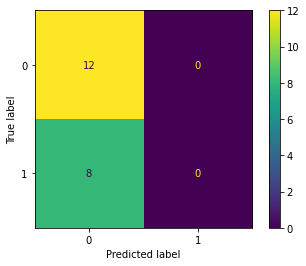

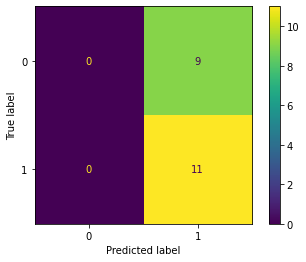

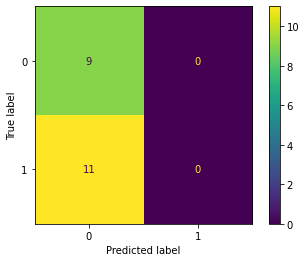

In [29]:
accuracy_list_gru = []
recall_list_gru = []
precision_list_gru = []
for _ in range(3):
    N = 100
    m = 5

    Y = eta = np.zeros((N, m))
    Age = np.random.choice(range(age_range[0], age_range[1] + 1), size=N)
    MMSE = np.round(np.random.normal(mu_MMSE, sigma_MMSE, size=N))
    EDUC = np.round(np.random.normal(mu_EDUC, sigma_EDUC, size=N))
    Sex = np.random.binomial(1, 0.2, size=N)
    eTIV = np.round(np.random.normal(mu_eTIV, sigma_eTIV, size=N))
    ASF = np.random.normal(size=N)
    nWBV = np.random.normal(size=N)
    Visit = np.round(np.linspace(0, 4, num=m))

    B = np.array([0.1, -0.1, 0.2, -0.2, 0.3, 0.3, 0.1, 0.1, 0.2, 0.1])
    b = np.random.normal(0, 0.5, size = N)

    for i in range(N):
        for j in range(m):
            eta[i, j] = B[0] + B[1] * Visit[j] + B[2] * Age[i] + B[3] * MMSE[i] + B[4] * EDUC[i] + B[5] * Sex[i] + \
                        B[6] * eTIV[i] + B[7] * ASF[i] + B[8] * nWBV[i] + b[i]
            p = scipy.special.expit(eta[i, j])
            Y[i, j] = np.random.binomial(1, p)



    mat = np.empty((N * m, 10))
    p = 0
    for i in range(N):
        jk = 0
        for jj in range(p, p + m):
            mat[jj, 0] = i + 1
            mat[jj, 1] = Visit[jk]
            mat[jj, 2] = Age[i]
            mat[jj, 3] = MMSE[i]
            mat[jj, 4] = EDUC[i]
            mat[jj, 5] = Sex[i]
            mat[jj, 6] = eTIV[jk]
            mat[jj, 7] = ASF[jk]
            mat[jj, 8] = nWBV[jk]
            mat[jj, 9] = Y[i, jk]
            jk += 1
        p += m
    # Convert the `mat` array to a DataFrame
    df_mat = pd.DataFrame(mat, columns=['ID', 'Visit', 'Age', 'MMSE', 'EDUC', 'Sex', 'eTIV', 'ASF', 'nWBV', 'Y'])
    df = pd.get_dummies(df_mat, columns=["Visit"], prefix="Visit")
    RANDOM_STATE = 13
    splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state=RANDOM_STATE)
    split = splitter.split(df, groups=df['ID'])
    train_indexes, test_indexes = next(split)

    X_train = df.iloc[train_indexes]
    X_test = df.iloc[test_indexes]
    age_scaler = MinMaxScaler()
    educ_scaler = MinMaxScaler()
    mmse_scaler = MinMaxScaler()
    etiv_scaler = MinMaxScaler()

    age_scaler.fit(X_train["Age"].to_numpy().reshape(-1, 1))
    educ_scaler.fit(X_train["EDUC"].to_numpy().reshape(-1, 1))
    mmse_scaler.fit(X_train["MMSE"].to_numpy().reshape(-1, 1))
    etiv_scaler.fit(X_train["eTIV"].to_numpy().reshape(-1, 1))

    X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1, 1))
    X_train["EDUC"] = educ_scaler.transform(X_train["EDUC"].to_numpy().reshape(-1, 1))
    X_train["MMSE"] = mmse_scaler.transform(X_train["MMSE"].to_numpy().reshape(-1, 1))
    X_train["eTIV"] = etiv_scaler.transform(X_train["eTIV"].to_numpy().reshape(-1, 1))

    X_test["Age"] = age_scaler.transform(X_test["Age"].to_numpy().reshape(-1, 1))
    X_test["EDUC"] = educ_scaler.transform(X_test["EDUC"].to_numpy().reshape(-1, 1))
    X_test["MMSE"] = mmse_scaler.transform(X_test["MMSE"].to_numpy().reshape(-1, 1))
    X_test["eTIV"] = mmse_scaler.transform(X_test["eTIV"].to_numpy().reshape(-1, 1))
    visit_4_train = X_train[X_train["Visit_4.0"] == 1][["ID", "Y"]]
    y_train_final = []
    for id in X_train["ID"].unique():
        y_train_final.append(visit_4_train[visit_4_train["ID"] == id]["Y"].values[0])

    visit_4_test = X_test[X_test["Visit_4.0"] == 1][["ID", "Y"]]
    y_test_final = []
    for id in X_test["ID"].unique():
        y_test_final.append(visit_4_test[visit_4_test["ID"] == id]["Y"].values[0])


    y_train_super_final = pd.DataFrame({
    "Group": y_train_final})
    y_test_super_final = pd.DataFrame({
    "Group": y_test_final})
    X_test_final = X_test.drop(["ID"], axis = 1)
    X_train_final = X_train.drop(["ID"], axis = 1)
    rows_n = 5
    X_train_super_final = np.reshape(X_train_final.to_numpy(),(X_train_final.shape[0]//5,X_train_final.shape[1],rows_n))
    X_test_super_final = np.reshape(X_test_final.to_numpy(),(X_test_final.shape[0]//5,X_train_final.shape[1],rows_n))
    EPOCH_NUM = 3
    gru_rnn = build_gru_rnn((X_train_super_final.shape[1],X_train_super_final.shape[2]) )
    gru_rnn.fit(X_train_super_final, y_train_super_final, epochs = EPOCH_NUM, verbose = 0)
    not_final_gru_rnn_prediction = gru_rnn.predict(X_test_super_final)
    gru_rnn_prediction = np.where(not_final_gru_rnn_prediction > 0.5, 1, 0)
    gru_rnn_conf = confusion_matrix(y_test_super_final,gru_rnn_prediction)
    gru_rnn_plot_conf = ConfusionMatrixDisplay(gru_rnn_conf)
    gru_rnn_plot_conf.plot()    
    TP=gru_rnn_conf[1,1]
    FP=gru_rnn_conf[0,1]
    TN=gru_rnn_conf[0,0]
    FN=gru_rnn_conf[1,0]
    accuracy=(TP+TN)/(TP+FP+FN+TN)
    recall =TP/(TP+FN)
    precision =TP/(TP+TN)
    accuracy_list_gru.append(accuracy)
    recall_list_gru.append(recall)
    precision_list_gru.append(precision)

print("Accuracy List:", accuracy_list_gru)
print("Recall List:", recall_list_gru)
print("Precision List:", precision_list_gru)

In [30]:
print("Accuracy List:", accuracy_list_gru)

Accuracy List: [0.6, 0.55, 0.45]


In [31]:
print("Recall List:", recall_list_gru)

Recall List: [0.0, 1.0, 0.0]


In [32]:
print("Precision List:", precision_list_gru)

Precision List: [0.0, 1.0, 0.0]


In [33]:
mean_accuracy_list_gru = np.mean(accuracy_list_gru)
mean_recall_list_gru = np.mean(recall_list_gru)
mean_precision_list_gru = np.mean(precision_list_gru)
print("mean_accuracy:",mean_accuracy_list_gru, "mean_recall:",mean_recall_list_gru,"mean_precision:",mean_precision_list_gru)

mean_accuracy: 0.5333333333333333 mean_recall: 0.3333333333333333 mean_precision: 0.3333333333333333
